In [1]:
import numpy as np 
import pandas as pd 

import tqdm

import os

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [3]:
# arr = []
# for folder_name in os.listdir(path):
#     arr.append(folder_name)
# np.array(arr)

In [4]:
use_names = ['Tram Acceleration Full','Tram Full', 'Tram Ring Full', 'Tram Braking Full']

In [5]:
CLASSES = [i for i in range(len(use_names))]
CLASSES

[0, 1, 2, 3]

In [6]:
# BIG_CLASSES_NAMES = {'Tram Acceleration Full': 0, 'Tram Braking Full': 0, 'Tram Full': 0, 'Tram Ring Full': 0, 'Car Horn Full': 1, 'Car Idling Full': 1, 'Car acceleration Full': 1, 'Car braking Full': 1}

In [7]:
# BIG_CLASSES = [0, 1]

In [8]:
IS_BIG_CLASSES = False

In [9]:
path = '/kaggle/input/new-sounds-2024/new sounds/'

In [10]:
def find_index(name):
    if IS_BIG_CLASSES:
        return BIG_CLASSES_NAMES[name]
    else:
        return use_names.index(folder_name)

In [11]:
def get_names():
    if IS_BIG_CLASSES:
        return BIG_CLASSES_NAMES
    else:
        return use_names

In [12]:
def get_classes():
    if IS_BIG_CLASSES:
        return BIG_CLASSES
    else:
        return CLASSES 

In [13]:
pr  = 0
file_format = 'wav'
for folder_name in os.listdir(path):
    if folder_name in get_names():
        print(folder_name)
        dataset = tf.data.Dataset.list_files(path + folder_name + '/*.' + file_format)
        dataset = tf.data.Dataset.zip((dataset, tf.data.Dataset.from_tensor_slices \
                                       (tf.keras.utils.to_categorical \
                                        ([find_index(folder_name)] * len(dataset), len(get_classes())))))
        if pr:
            data = pr.concatenate(dataset)
            pr = data
        else:
            pr = dataset

Tram Acceleration Full
Tram Full
Tram Ring Full
Tram Braking Full


In [14]:
len(data)

1231

In [15]:
# lengths = []
# for file in os.listdir(POS):
#     tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
#     lengths.append(len(tensor_wave))

In [16]:
# tf.math.reduce_mean(lengths)

In [17]:
# tf.math.reduce_min(lengths)

In [18]:
# tf.math.reduce_max(lengths)

In [19]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [20]:
def preprocess_for_predict(file_path): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.reshape(spectrogram, (1,spectrogram.shape[0], spectrogram.shape[1], spectrogram.shape[2]))
    return spectrogram

In [21]:
path, label = data.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(path, label)

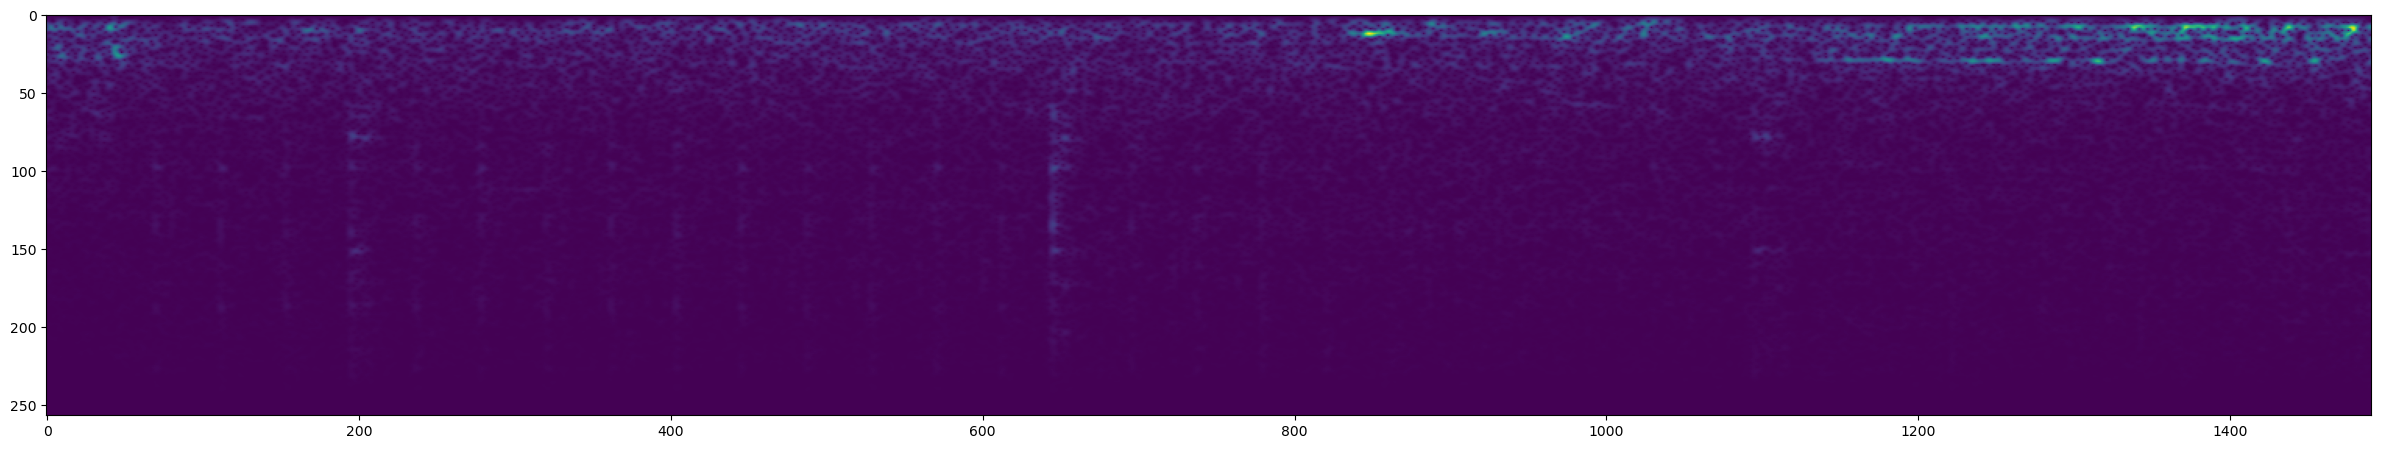

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [23]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.07266776e-01],
        [2.18789577e-01],
        [3.84068102e-01],
        ...,
        [8.11856517e-05],
        [3.99418313e-05],
        [2.44602561e-05]],

       [[1.07534647e-01],
        [2.04986289e-01],
        [3.91462177e-01],
        ...,
        [7.98340698e-05],
        [4.13985654e-05],
        [1.73151493e-05]],

       [[1.46081895e-02],
        [2.02025250e-01],
        [4.14160937e-01],
        ...,
        [6.43354142e-05],
        [1.33293888e-05],
        [6.02006912e-05]],

       ...,

       [[4.76940572e-02],
        [2.03712985e-01],
        [4.18316245e-01],
        ...,
        [8.02157374e-05],
        [1.19432538e-04],
        [8.22246075e-05]],

       [[9.75937098e-02],
        [1.35285959e-01],
        [2.85414159e-01],
        ...,
        [2.06293029e-04],
        [9.19105878e-05],
        [3.62992287e-05]],

       [[5.78527898e-02],
        [1.63784504e-01],
        [1.72201425e-01]

In [24]:
label, label.shape

(array([1., 0., 0., 0.], dtype=float32), (4,))

In [25]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(1)
# data = data.prefetch(8)

In [26]:
train_size = int(len(data)*.7)
test_size = len(data) - train_size
train_size, test_size

(861, 370)

In [27]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

In [28]:
model = Sequential()
model.add(Conv2D(1, kernel_size=(3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(1, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(get_classes()), activation='sigmoid'))

In [29]:
model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.Recall(thresholds=0),tf.keras.metrics.Precision(thresholds=0),
                       tfa.metrics.F1Score(num_classes=len(get_classes()))])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 1)      10        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 1)      10        
                                                                 
 flatten (Flatten)           (None, 376211)            0         
                                                                 
 dense (Dense)               (None, 128)               48155136  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 48,155,672
Trainable params: 48,155,672
Non-trainable params: 0
_________________________________________________________________


In [31]:
train

<TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [32]:
hist = model.fit(train, epochs=4)

Epoch 1/4


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


861/861 [==============================] - 571s 641ms/step - loss: 0.5095 - recall: 1.0000 - precision: 0.2500 - f1_score: 0.4626
Epoch 2/4
861/861 [==============================] - 549s 638ms/step - loss: 0.2430 - recall: 1.0000 - precision: 0.2500 - f1_score: 0.8492
Epoch 3/4
861/861 [==============================] - 548s 637ms/step - loss: 0.1149 - recall: 1.0000 - precision: 0.2500 - f1_score: 0.9388
Epoch 4/4
861/861 [==============================] - 545s 633ms/step - loss: 0.0409 - recall: 1.0000 - precision: 0.2501 - f1_score: 0.9766


In [33]:
model.save('model2024')

In [34]:
y_pred = []
y_test_all = []
for i in range(len(test)):
    X_test, y_test = test.as_numpy_iterator().next()
    yhat = model.predict(X_test, verbose = 0)
    y_pred.append(np.argmax(yhat,axis=1)[0])
    y_test_all.append(np.argmax(y_test, axis=1)[0])

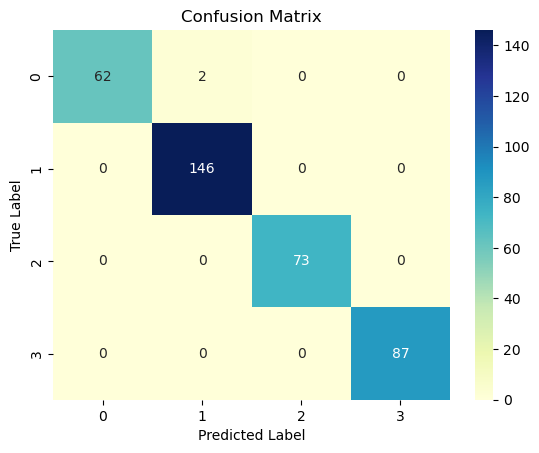

In [35]:
# Compute confusion matrix
y_true = list(y_test_all)
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [36]:
#test model
# model = tf.keras.models.load_model('/kaggle/input/best-model-for-3-11-16/new_best_model_3_11_16')
# np.argmax(model.predict(preprocess_for_predict('/kaggle/input/random/AB_25.wav')), axis=1)

In [37]:
!zip -r output.zip ./

  adding: __notebook__.ipynb (deflated 75%)
  adding: model2024/ (stored 0%)
  adding: model2024/fingerprint.pb (stored 0%)
  adding: model2024/assets/ (stored 0%)
  adding: model2024/saved_model.pb (deflated 88%)
  adding: model2024/variables/ (stored 0%)
  adding: model2024/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: model2024/variables/variables.index (deflated 64%)
  adding: model2024/keras_metadata.pb (deflated 89%)
